# LAT Workshop Tutorial #2: EMRIs and LISA Response + TDI

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful

In the second tutorial, we will

* generate EMRI waveforms,
* use tools from our last lesson to estimate EMRI SNRs,
* examine changing EMRI trajectories,
* add in the LISA response function,
* and calculate Likelihoods for EMRIs + Response + Trajectory. 

## Task 1: Generate an EMRI Waveform for a typical EMRI

Generate a relativistic Schwarzschild eccentric EMRI Waveform in the detector frame (use `GenerateEMRIWaveform` class rather than `FastSchwarzschildEccentricFlux`. Choose a set of reasonable parameters.

Useful documentation:
* [GenerateEMRIWaveform](https://bhptoolkit.org/FastEMRIWaveforms/html/user/main.html#few.waveform.GenerateEMRIWaveform)
* [FastSchwarzschildEccentricFlux](https://bhptoolkit.org/FastEMRIWaveforms/html/user/main.html#few.waveform.FastSchwarzschildEccentricFlux)

In [2]:
# imports
from few.waveform import GenerateEMRIWaveform

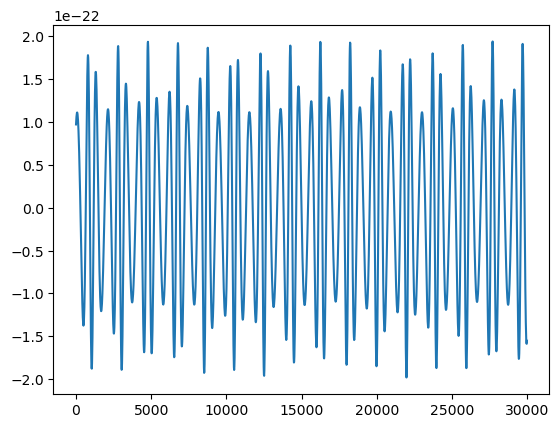

In [3]:
gen_wave = GenerateEMRIWaveform("FastSchwarzschildEccentricFlux")

# parameters
T = 0.1  # years
dt = 15.0  # seconds
M = 1e6
a = 0.1  # will be ignored in Schwarzschild waveform
mu = 1e1
p0 = 12.0
e0 = 0.2
x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = 0.2  # polar spin angle
phiK = 0.2  # azimuthal viewing angle
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal viewing angle
dist = 1.0  # distance
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

plt.plot(np.arange(2000) * dt, h.real[:2000])

### Question

Why does the EMRI waveform look like that? This is obviously a very open-ended question. Try to decipher why the waveform has such a structure in terms of the compact object orbits.

## Task 2: Add the LISA response function

When actually building the LISA response function in the time-domain, the edges of the data can be complicated. This is due to the various delays included in the instrument response and Time Delay Interferometry (TDI) transforms. In short, summations between the waveform at the current time and times in the past require that we start our computations a bit after the beginning of observation: if you cannot reach into the past enough (i.e. the delay causes the time to be less than 0.0).

Now we will wrap the EMRI waveforms in LISA response using `ResponseWrapper` from `fastlisasresponse`.

Useful documentation:
* [ResponseWrapper](https://mikekatz04.github.io/lisa-on-gpu/html/user/main.html#fastlisaresponse.response.ResponseWrapper)
* [pyResponseTDI](https://mikekatz04.github.io/lisa-on-gpu/html/user/main.html#fastlisaresponse.response.pyResponseTDI)
* [EqualArmlengthOrbits](https://mikekatz04.github.io/LISAanalysistools/build/html/user/main.html#lisatools.detector.EqualArmlengthOrbits)

In [4]:
# imports
from fastlisaresponse import ResponseWrapper
from lisatools.detector import EqualArmlengthOrbits

In [5]:
sampling_frequency = 1 / dt
t0 = 20000.0
# order of the langrangian interpolation
order = 25

orbits = EqualArmlengthOrbits()

# 1st or 2nd or custom (see docs for custom)
tdi_gen = "1st generation"

index_lambda = 8
index_beta = 7

tdi_kwargs = dict(
    order=order, tdi=tdi_gen, tdi_chan="AET",
)

emri_lisa = ResponseWrapper(
    gen_wave,
    T,
    dt,
    index_lambda,
    index_beta,
    t0=t0,
    flip_hx=True,  # set to True if waveform is h+ - ihx
    remove_sky_coords=False,  # True if the waveform generator does not take sky coordinates
    is_ecliptic_latitude=False,  # False if using polar angle (theta)
    remove_garbage=True,  # removes the beginning of the signal that has bad information
    orbits=orbits,
    **tdi_kwargs,
)

In [ ]:
AET = emri_lisa(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
)

In [ ]:
emri_lisa.response_model.num_total_points

In [ ]:
start_ind = int(t0 / dt)
num = 500
fig, ax = plt.subplots(3, 1, sharex=True)

for i in range(3):
    ax[i].plot((start_ind + np.arange(num)) * dt, AET[i][:num], color=f"C{i}")


### Question

With a long-enough observation time, you will see a new envelope structure to the waveforms when the response is added. Why is that? 

If you want to use `ResponseWrapper` with another type of waveform, the above cells are how you do that. If you want to use `GenerateEMRIWaveform` and `ResponseWrapper` together, you can use the stock model from LISA Analysis Tools: [EMRITDIWaveform](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sources.html#lisatools.sources.emri.EMRITDIWaveform). With this class, you do not have to set any choices. In this case, it will set it up with all defaults. Generate the same waveform above but now with the new class. 

Documentation:
* [EMRITDIWaveform](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sources.html#lisatools.sources.emri.EMRITDIWaveform)

In [ ]:
# imports
from lisatools.sources.emri import EMRITDIWaveform

In [ ]:
emri_lisa = EMRITDIWaveform(response_kwargs=dict(tdi_chan="AE"))

In [ ]:

AE = emri_lisa(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
)

In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True)

for i in range(2):
    ax[i].plot(AE[i])

## Task 3: Calculate SNR, inner product, and Likelihood

Now we will combine our knowledge from tutorials 1 and 2 to calculate the SNR, inner product, and Likelihood for an EMRI.

Let's start by generating our data for *just* the A and E channels (do not worry about T for now). Be careful, make sure when using `EMRITDIWaveform`, you initialize with the keyword argument `response_kwargs=dict(tdi_chan="AE")` to remove the T channel. Fill a [DataResidualArray](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#lisatools.datacontainer.DataResidualArray) with the data. Plot it if you would like. 

In [ ]:
from lisatools.datacontainer import DataResidualArray

In [ ]:
AE = emri_lisa(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
)

data = DataResidualArray(AE, dt=dt)

In [ ]:
data.loglog()

Now let's build the [SensitivityMatrix](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.SensitivityMatrix). Remeber, we now have the response function included. Therefore, we do not want to use [LISASens](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.LISASens). Rather, we will use the TDI sensitivity functions: [A1TDISens](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.A1TDISens), [E1TDISens](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.E1TDISens).

In [ ]:
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens

In [ ]:
sens_mat = SensitivityMatrix(data.f_arr, [A1TDISens, E1TDISens])

Now pack them both into the [AnalysisContainer](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#lisatools.analysiscontainer.AnalysisContainer) and calculate the SNR of the injection data.

In [ ]:
from lisatools.analysiscontainer import AnalysisContainer

In [ ]:
analysis = AnalysisContainer(data, sens_mat, signal_gen=emri_lisa)

In [ ]:
analysis.loglog()

In [ ]:
analysis.snr()

Now, let's calculate the Likelihood using `AnalysisContainer.calculate_signal_likelihood`. This allows us to compare another EMRI signal to our injection. Start by injecting a source with the correct injection parameters. What is the Likelihood here? Now change the source parameters slightly one at a time and observe how the Likelihood changes. This can give you a sense of the complicated multidimensional Likelihood surface which we wish to learn. Since we are fixing the sensitivity for now, add the `source_only=False` keyword argument. 

In [ ]:
analysis.calculate_signal_likelihood(
    M * 1.00000005,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    source_only=True
)

## Task 4: Determine 1$\sigma$ width in 1-dimension using the Likelihood

In one dimension, the 1$\sigma$ Likelihood width can be determined by solving $\log{\mathcal{L(\vec{\theta})}} = -1$. Using a loop, plot the Likelihood versus one parameter you decide to change. Make sure the Likelihoods are all of order $\sim1$, so close to the true value.

In [ ]:
x = np.linspace(-0.01, 0.01, 20)
y = np.zeros_like(x)
for i in range(len(x)):
    diff = 1.0 + x[i]
    y[i] = analysis.calculate_signal_likelihood(
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist * diff,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
        source_only=True,
        waveform_kwargs=dict(modes=[(2, 2, 0)])
    )


Use whatever method you prefer to determine the $1\sigma$ width. You can eyeball it or use plotting. We are just estimating the value for now. 

In [ ]:
plt.plot(x, y)
plt.axhline(-1.0, ls='--')
plt.axvline(-0.0057, color='C1', ls='--')
plt.axvline(+0.0057, color='C1', ls='--')
# 0.0057 is the 1 sigma posterior width estimate in 1D for the distance.

## Task 5: analyze a GR modification or environmental effect

Now we will look at a very useful aspect of `few`: testing beyond-GR or environmental effects by adding terms to the Trajectory. Here, we will use a modified trajectory that we have already put together for you. The modificiation is `pdot = pdot * (1 + mod)` and `edot = edot * (1 + mod)`.

It is imported below (`ModifiedPnTrajectory`). It is a basic PN trajectory in the Schwarzschild eccentric limit. This is effectively lifted from the `few` tutorial (adding the GR modification). For the amplitude module, use `Interp2DAmplitude` and for the summation use `InterpolatedModeSum`. **Hint**: You are created a class object that inherits `SchwarzschildEccentricWaveformBase` and initializes it with the proper modules. See the tutorial. It does this exactly.

Documentation:
* [SchwarzschildEccentricWaveformBase](https://bhptoolkit.org/FastEMRIWaveforms/html/user/main.html#few.waveform.SchwarzschildEccentricWaveformBase)
* [Make waveform tutorial](https://bhptoolkit.org/FastEMRIWaveforms/html/tutorial/FastEMRIWaveforms_tutorial.html#Make-a-waveform-model)

In [ ]:
from pnbeyondGR_example import ModifiedPnTrajectory
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum

Create the waveform generator class to start. 

In [ ]:
class FastSchwarzschildEccentricPn(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            PnTrajectory,
            Interp2DAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

Now use `EMRITDIWaveform` to create a full TDI version of this waveform. **Hint**: use the `emri_waveform_args` keyword argument for the EMRITDIWaveform. Also, use just the A and E channels. Supply the `response_kwargs` keyword argument to specify this. Build the injection waveforms and place them in a `DataResidualArray`. Then, fill an `AnalysisContainer` with the sensitivity matrix, data, and signal generator as we have done before. **Hint**: the modification parameter will be added as the last parameter.

In [ ]:
new_emri_lisa = EMRITDIWaveform(emri_waveform_args=(FastSchwarzschildEccentricPn,), response_kwargs=dict(tdi_chan="AE"))

In [ ]:
modification = 0.0

injection = new_emri_lisa(
     M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    modification
)

data = DataResidualArray(injection, dt=dt)
analysis = AnalysisContainer(data, sens_mat, signal_gen=new_emri_lisa)

Now do some basic calculations (Likelihood, overlap, etc.) to understand how the added effect changes our waveform. **Hint**: you can get the overlap by calculating the inner product with the keyword argument `normalize=True`. 

In [ ]:
analysis.calculate_signal_likelihood(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    0.00001,
    source_only=True
)

In [ ]:
analysis.calculate_signal_inner_product(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    0.00001,
    normalize=True
)